In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from keras.layers import Dense, Input, Activation
from keras.layers import BatchNormalization,Add,Dropout
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import callbacks
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)
import os
import gc
#%cd /kaggle/input/champs-scalar-coupling
#print(os.listdir("."))
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


## First grab the data.
I don't like to clutter up my solution notebooks with my EDA work.  That's usually a separate notebook.

In [2]:
df_train =pd.read_csv('../input/train.csv')
df_test  =pd.read_csv('../input/test.csv')
df_struct=pd.read_csv('../input/structures.csv')

df_train_sub_charge=pd.read_csv('../input/mulliken_charges.csv')
df_train_sub_tensor=pd.read_csv('../input/magnetic_shielding_tensors.csv')


## Reduce the Memory Usage
Without this call, this kernel definitely can't be run on smaller cloud instances... I always test solutions on CoLaboratory to see if low-resource nodes can process them.  In this case, CoLab can't unless you reduce down.  The results seem similar to when the same network is trained on the full dataset.

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
print(df_train.shape, df_test.shape, df_struct.shape, df_train_sub_charge.shape, df_train_sub_tensor.shape)
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)
df_struct = reduce_mem_usage(df_struct)
df_train_sub_charge = reduce_mem_usage(df_train_sub_charge)
df_train_sub_tensor = reduce_mem_usage(df_train_sub_tensor)
print(df_train.shape, df_test.shape, df_struct.shape, df_train_sub_charge.shape, df_train_sub_tensor.shape)

(4658147, 6) (2505542, 5) (2358657, 6) (1533537, 3) (1533537, 11)
Mem. usage decreased to 106.62 Mb (50.0% reduction)
Mem. usage decreased to 52.57 Mb (45.0% reduction)
Mem. usage decreased to 51.74 Mb (52.1% reduction)
Mem. usage decreased to 16.09 Mb (54.2% reduction)
Mem. usage decreased to 39.49 Mb (69.3% reduction)
(4658147, 6) (2505542, 5) (2358657, 6) (1533537, 3) (1533537, 11)


## Map data into a master dataframe
Here's the code to do mappings.  The drop_duplicates is important, else your test dataset will grow and your predictions will not be output correctly.

In [4]:
''' 
Map atom info from the structures.csv into the train/test files
'''
import psutil
import os

def map_atom_info(df_1,df_2, atom_idx):
    print('Mapping...', df_1.shape, df_2.shape, atom_idx)
    
    df = pd.merge(df_1, df_2.drop_duplicates(subset=['molecule_name', 'atom_index']), how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)

    return df

def show_ram_usage():
    py = psutil.Process(os.getpid())
    print('RAM usage: {} GB'.format(py.memory_info()[0]/2. ** 30))

show_ram_usage()

for atom_idx in [0,1]:
    df_train = map_atom_info(df_train,df_struct, atom_idx)
    df_train = map_atom_info(df_train,df_train_sub_charge, atom_idx)
    df_train = map_atom_info(df_train,df_train_sub_tensor, atom_idx)
    df_train = df_train.rename(columns={'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}',
                                        'mulliken_charge': f'charge_{atom_idx}',
                                        'XX': f'XX_{atom_idx}',
                                        'YX': f'YX_{atom_idx}',
                                        'ZX': f'ZX_{atom_idx}',
                                        'XY': f'XY_{atom_idx}',
                                        'YY': f'YY_{atom_idx}',
                                        'ZY': f'ZY_{atom_idx}',
                                        'XZ': f'XZ_{atom_idx}',
                                        'YZ': f'YZ_{atom_idx}',
                                        'ZZ': f'ZZ_{atom_idx}',})
    df_test = map_atom_info(df_test,df_struct, atom_idx)
    df_test = df_test.rename(columns={'atom': f'atom_{atom_idx}',
                                'x': f'x_{atom_idx}',
                                'y': f'y_{atom_idx}',
                                'z': f'z_{atom_idx}'})
    #add some features
    
    df_struct['c_x']=df_struct.groupby('molecule_name')['x'].transform('mean')
    df_struct['c_y']=df_struct.groupby('molecule_name')['y'].transform('mean')
    df_struct['c_z']=df_struct.groupby('molecule_name')['z'].transform('mean')
    df_struct['atom_n']=df_struct.groupby('molecule_name')['atom_index'].transform('max')
    
    show_ram_usage()
    print(df_train.shape, df_test.shape)

RAM usage: 0.4962577819824219 GB
Mapping... (4658147, 6) (2358657, 6) 0
Mapping... (4658147, 10) (1533537, 3) 0
Mapping... (4658147, 11) (1533537, 11) 0
Mapping... (2505542, 5) (2358657, 6) 0
RAM usage: 0.787841796875 GB
(4658147, 20) (2505542, 9)
Mapping... (4658147, 20) (2358657, 10) 1
Mapping... (4658147, 28) (1533537, 3) 1
Mapping... (4658147, 29) (1533537, 11) 1
Mapping... (2505542, 9) (2358657, 10) 1
RAM usage: 1.0147781372070312 GB
(4658147, 38) (2505542, 17)


## Start developing more complex features

In [5]:
def make_features(df):
    df['dx']=df['x_1']-df['x_0']
    df['dy']=df['y_1']-df['y_0']
    df['dz']=df['z_1']-df['z_0']
    df['distance']=(df['dx']**2+df['dy']**2+df['dz']**2)**(1/2)
    return df

df_train=make_features(df_train)
df_test=make_features(df_test) 
#df_train = reduce_mem_usage(df_train)
#df_test = reduce_mem_usage(df_test)
test_prediction=np.zeros(len(df_test))
show_ram_usage()
print(df_train.shape, df_test.shape)

def get_dist(df):
    df_temp=df.loc[:,["molecule_name","atom_index_0","atom_index_1","distance","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
    df_temp_=df_temp.copy()
    df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                       'atom_index_1': 'atom_index_0',
                                       'x_0': 'x_1',
                                       'y_0': 'y_1',
                                       'z_0': 'z_1',
                                       'x_1': 'x_0',
                                       'y_1': 'y_0',
                                       'z_1': 'z_0'})
    df_temp_all=pd.concat((df_temp,df_temp_),axis=0)

    df_temp_all["min_distance"]=df_temp_all.groupby(['molecule_name', 'atom_index_0'])['distance'].transform('min')
    df_temp_all["max_distance"]=df_temp_all.groupby(['molecule_name', 'atom_index_0'])['distance'].transform('max')
    
    df_temp= df_temp_all[df_temp_all["min_distance"]==df_temp_all["distance"]].copy()
    df_temp=df_temp.drop(['x_0','y_0','z_0','min_distance'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                         'atom_index_1': 'atom_index_closest',
                                         'distance': 'distance_closest',
                                         'x_1': 'x_closest',
                                         'y_1': 'y_closest',
                                         'z_1': 'z_closest'})
    
    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                        'distance_closest': f'distance_closest_{atom_idx}',
                                        'x_closest': f'x_closest_{atom_idx}',
                                        'y_closest': f'y_closest_{atom_idx}',
                                        'z_closest': f'z_closest_{atom_idx}'})
        
    df_temp= df_temp_all[df_temp_all["max_distance"]==df_temp_all["distance"]].copy()
    df_temp=df_temp.drop(['x_0','y_0','z_0','max_distance'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                         'atom_index_1': 'atom_index_farthest',
                                         'distance': 'distance_farthest',
                                         'x_1': 'x_farthest',
                                         'y_1': 'y_farthest',
                                         'z_1': 'z_farthest'})
        
    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_farthest': f'atom_index_farthest_{atom_idx}',
                                        'distance_farthest': f'distance_farthest_{atom_idx}',
                                        'x_farthest': f'x_farthest_{atom_idx}',
                                        'y_farthest': f'y_farthest_{atom_idx}',
                                        'z_farthest': f'z_farthest_{atom_idx}'})
    return df
df_test=(get_dist(df_test))    
df_train=(get_dist(df_train)) 

print(df_train.shape, df_test.shape)
show_ram_usage()

RAM usage: 1.0710029602050781 GB
(4658147, 42) (2505542, 21)
Mapping... (2505542, 21) (790486, 8) 0
Mapping... (2505542, 27) (790486, 8) 1
Mapping... (2505542, 33) (775149, 8) 0
Mapping... (2505542, 39) (775149, 8) 1
Mapping... (4658147, 42) (1468792, 8) 0
Mapping... (4658147, 48) (1468792, 8) 1
Mapping... (4658147, 54) (1440019, 8) 0
Mapping... (4658147, 60) (1440019, 8) 1
(4658147, 66) (2505542, 45)
RAM usage: 1.366363525390625 GB


## Here is where the Cosine Distance features are Created

In [6]:
def add_features(df):
    df["distance_center0"]=((df['x_0']-df['c_x'])**2+(df['y_0']-df['c_y'])**2+(df['z_0']-df['c_z'])**2)**(1/2)
    df["distance_center1"]=((df['x_1']-df['c_x'])**2+(df['y_1']-df['c_y'])**2+(df['z_0']-df['c_z'])**2)**(1/2)
    df["distance_c0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["distance_c1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df["distance_f0"]=((df['x_0']-df['x_farthest_0'])**2+(df['y_0']-df['y_farthest_0'])**2+(df['z_0']-df['z_farthest_0'])**2)**(1/2)
    df["distance_f1"]=((df['x_1']-df['x_farthest_1'])**2+(df['y_1']-df['y_farthest_1'])**2+(df['z_1']-df['z_farthest_1'])**2)**(1/2)
    df["vec_center0_x"]=(df['x_0']-df['c_x'])/(df["distance_center0"]+1e-10)
    df["vec_center0_y"]=(df['y_0']-df['c_y'])/(df["distance_center0"]+1e-10)
    df["vec_center0_z"]=(df['z_0']-df['c_z'])/(df["distance_center0"]+1e-10)
    df["vec_center1_x"]=(df['x_1']-df['c_x'])/(df["distance_center1"]+1e-10)
    df["vec_center1_y"]=(df['y_1']-df['c_y'])/(df["distance_center1"]+1e-10)
    df["vec_center1_z"]=(df['z_1']-df['c_z'])/(df["distance_center1"]+1e-10)
    df["vec_c0_x"]=(df['x_0']-df['x_closest_0'])/(df["distance_c0"]+1e-10)
    df["vec_c0_y"]=(df['y_0']-df['y_closest_0'])/(df["distance_c0"]+1e-10)
    df["vec_c0_z"]=(df['z_0']-df['z_closest_0'])/(df["distance_c0"]+1e-10)
    df["vec_c1_x"]=(df['x_1']-df['x_closest_1'])/(df["distance_c1"]+1e-10)
    df["vec_c1_y"]=(df['y_1']-df['y_closest_1'])/(df["distance_c1"]+1e-10)
    df["vec_c1_z"]=(df['z_1']-df['z_closest_1'])/(df["distance_c1"]+1e-10)
    df["vec_f0_x"]=(df['x_0']-df['x_farthest_0'])/(df["distance_f0"]+1e-10)
    df["vec_f0_y"]=(df['y_0']-df['y_farthest_0'])/(df["distance_f0"]+1e-10)
    df["vec_f0_z"]=(df['z_0']-df['z_farthest_0'])/(df["distance_f0"]+1e-10)
    df["vec_f1_x"]=(df['x_1']-df['x_farthest_1'])/(df["distance_f1"]+1e-10)
    df["vec_f1_y"]=(df['y_1']-df['y_farthest_1'])/(df["distance_f1"]+1e-10)
    df["vec_f1_z"]=(df['z_1']-df['z_farthest_1'])/(df["distance_f1"]+1e-10)
    df["vec_x"]=(df['x_1']-df['x_0'])/df["distance"]
    df["vec_y"]=(df['y_1']-df['y_0'])/df["distance"]
    df["vec_z"]=(df['z_1']-df['z_0'])/df["distance"]
    df["cos_c0_c1"]=df["vec_c0_x"]*df["vec_c1_x"]+df["vec_c0_y"]*df["vec_c1_y"]+df["vec_c0_z"]*df["vec_c1_z"]
    df["cos_f0_f1"]=df["vec_f0_x"]*df["vec_f1_x"]+df["vec_f0_y"]*df["vec_f1_y"]+df["vec_f0_z"]*df["vec_f1_z"]
    df["cos_center0_center1"]=df["vec_center0_x"]*df["vec_center1_x"]+df["vec_center0_y"]*df["vec_center1_y"]+df["vec_center0_z"]*df["vec_center1_z"]
    df["cos_c0"]=df["vec_c0_x"]*df["vec_x"]+df["vec_c0_y"]*df["vec_y"]+df["vec_c0_z"]*df["vec_z"]
    df["cos_c1"]=df["vec_c1_x"]*df["vec_x"]+df["vec_c1_y"]*df["vec_y"]+df["vec_c1_z"]*df["vec_z"]
    df["cos_f0"]=df["vec_f0_x"]*df["vec_x"]+df["vec_f0_y"]*df["vec_y"]+df["vec_f0_z"]*df["vec_z"]
    df["cos_f1"]=df["vec_f1_x"]*df["vec_x"]+df["vec_f1_y"]*df["vec_y"]+df["vec_f1_z"]*df["vec_z"]
    df["cos_center0"]=df["vec_center0_x"]*df["vec_x"]+df["vec_center0_y"]*df["vec_y"]+df["vec_center0_z"]*df["vec_z"]
    df["cos_center1"]=df["vec_center1_x"]*df["vec_x"]+df["vec_center1_y"]*df["vec_y"]+df["vec_center1_z"]*df["vec_z"]
    df=df.drop(['vec_c0_x','vec_c0_y','vec_c0_z','vec_c1_x','vec_c1_y','vec_c1_z',
                'vec_f0_x','vec_f0_y','vec_f0_z','vec_f1_x','vec_f1_y','vec_f1_z',
                'vec_center0_x','vec_center0_y','vec_center0_z','vec_center1_x','vec_center1_y','vec_center1_z',
                'vec_x','vec_y','vec_z'], axis=1)
    return df
    
df_train=add_features(df_train)
df_test=add_features(df_test)
print(df_train.shape, df_test.shape)
show_ram_usage()

(4658147, 81) (2505542, 60)
RAM usage: 1.5665969848632812 GB


## Here you add the external extra features

In [7]:
train6 = pd.read_csv( '../input/train-6.csv' )
test6  = pd.read_csv( '../input/test-6.csv' )

train6 = reduce_mem_usage(train6)
test6  = reduce_mem_usage(test6)

train6.shape, test6.shape

Mem. usage decreased to 550.85 Mb (75.0% reduction)
Mem. usage decreased to 296.29 Mb (75.0% reduction)


((4658147, 62), (2505542, 62))

In [8]:
train6.drop( ['id','typei'], inplace=True, axis=1 )
test6.drop(  ['id','typei'], inplace=True, axis=1 )
train6.head()

,link0,dist_xyz,inv_dist0,inv_dist1,inv_distP,inv_dist0R,inv_dist1R,inv_distPR,inv_dist0E,linkM0,...,tertiary_angle_6,tertiary_angle_7,tertiary_distance_0,tertiary_distance_1,tertiary_distance_2,tertiary_distance_3,tertiary_distance_4,tertiary_distance_5,tertiary_distance_6,tertiary_distance_7
0,1,1.091797,0.561035,0.298096,5.136719,0.003338,0.000843,0.000673,2.910156,0.0,...,NaN,NaN,1.783203,1.783203,1.783203,NaN,NaN,NaN,NaN,NaN
1,1,1.783203,0.561035,3.179688,2.097656,0.003338,1.046875,0.003326,2.910156,0.0,...,NaN,NaN,1.091797,1.783203,1.783203,NaN,NaN,NaN,NaN,NaN
2,1,1.783203,0.561035,1.589844,2.412109,0.003338,0.523438,0.003317,2.910156,0.0,...,NaN,NaN,1.091797,1.783203,1.783203,NaN,NaN,NaN,NaN,NaN
3,1,1.783203,0.561035,1.059570,2.726562,0.003338,0.348877,0.003305,2.910156,0.0,...,NaN,NaN,1.091797,1.783203,1.783203,NaN,NaN,NaN,NaN,NaN
4,2,1.091797,0.681152,0.298096,4.824219,0.003347,0.000843,0.000673,3.587891,0.0,...,NaN,NaN,1.783203,1.783203,1.783203,NaN,NaN,NaN,NaN,NaN


In [9]:
df_train.sort_values('id', inplace=True)
df_test.sort_values( 'id', inplace=True)
df_train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,...,distance_f1,cos_c0_c1,cos_f0_f1,cos_center0_center1,cos_c0,cos_c1,cos_f0,cos_f1,cos_center0,cos_center1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.812500,H,0.002150,-0.006031,0.001976,...,1.091797,-1.000000,-0.816406,0.000145,-1.000000,1.000000,-0.816406,1.000000,-1.000000,-0.000144
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,...,1.783203,-0.333496,-0.500488,-0.333496,-0.816406,0.817383,-1.000000,0.500488,-0.816406,0.817383
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,...,1.783203,-0.333252,-0.000041,-0.567871,-0.816406,0.816895,-0.499756,0.500488,-0.816895,1.392578
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,...,1.783203,-0.333008,-0.500000,-0.585449,-0.816406,0.816406,-0.500000,0.999512,-0.816406,1.435547
4,4,dsgdb9nsd_000001,2,0,1JHC,84.812500,H,1.011719,1.463867,0.000277,...,1.091797,0.333496,0.000189,0.007412,-1.000977,-0.333496,-0.816895,-0.333496,-1.000977,-0.007412


In [11]:
#Impute NA with mean

MEAN = pd.concat([train6,test6]).mean()
train6.fillna( value=MEAN, inplace=True )
test6.fillna( value=MEAN, inplace=True )
train6.head()

,link0,dist_xyz,inv_dist0,inv_dist1,inv_distP,inv_dist0R,inv_dist1R,inv_distPR,inv_dist0E,linkM0,...,tertiary_angle_6,tertiary_angle_7,tertiary_distance_0,tertiary_distance_1,tertiary_distance_2,tertiary_distance_3,tertiary_distance_4,tertiary_distance_5,tertiary_distance_6,tertiary_distance_7
0,1,1.091797,0.561035,0.298096,5.136719,0.003338,0.000843,0.000673,2.910156,0.0,...,1.399414,1.49707,1.783203,1.783203,1.783203,2.365234,2.646484,2.873047,3.115234,3.376953
1,1,1.783203,0.561035,3.179688,2.097656,0.003338,1.046875,0.003326,2.910156,0.0,...,1.399414,1.49707,1.091797,1.783203,1.783203,2.365234,2.646484,2.873047,3.115234,3.376953
2,1,1.783203,0.561035,1.589844,2.412109,0.003338,0.523438,0.003317,2.910156,0.0,...,1.399414,1.49707,1.091797,1.783203,1.783203,2.365234,2.646484,2.873047,3.115234,3.376953
3,1,1.783203,0.561035,1.059570,2.726562,0.003338,0.348877,0.003305,2.910156,0.0,...,1.399414,1.49707,1.091797,1.783203,1.783203,2.365234,2.646484,2.873047,3.115234,3.376953
4,2,1.091797,0.681152,0.298096,4.824219,0.003347,0.000843,0.000673,3.587891,0.0,...,1.399414,1.49707,1.783203,1.783203,1.783203,2.365234,2.646484,2.873047,3.115234,3.376953


In [12]:
print(df_train.shape)
df_train = pd.concat( [df_train,train6], axis=1 )
df_test  = pd.concat( [df_test ,test6 ], axis=1 )
print(df_train.shape, df_test.shape)

(4658147, 81)
(4658147, 141) (2505542, 120)


In [13]:
print( df_train.columns[-61:] )

Index(['cos_center1', 'link0', 'dist_xyz', 'inv_dist0', 'inv_dist1',
       'inv_distP', 'inv_dist0R', 'inv_dist1R', 'inv_distPR', 'inv_dist0E',
       'linkM0', 'min_molecule_atom_0_dist_xyz',
       'mean_molecule_atom_0_dist_xyz', 'max_molecule_atom_0_dist_xyz',
       'sd_molecule_atom_0_dist_xyz', 'min_molecule_atom_1_dist_xyz',
       'mean_molecule_atom_1_dist_xyz', 'max_molecule_atom_1_dist_xyz',
       'distN0', 'distN1', 'bond_lengths_mean_y', 'bond_lengths_std_y',
       'yukawa_C.x', 'yukawa_H.x', 'yukawa_N.x', 'yukawa_O.x', 'yukawa_C.y',
       'yukawa_H.y', 'yukawa_N.y', 'yukawa_O.y', 'qm9_1', 'qm9_2', 'adH1',
       'adC1', 'adC2', 'adC3', 'adC4', 'adC5', 'adN1', 'adN2', 'F1dist1',
       'F1dist2', 'F1dist3', 'bond_atom', 'bond_distance', 'tertiary_angle_0',
       'tertiary_angle_1', 'tertiary_angle_2', 'tertiary_angle_3',
       'tertiary_angle_4', 'tertiary_angle_5', 'tertiary_angle_6',
       'tertiary_angle_7', 'tertiary_distance_0', 'tertiary_distance_1',
       '

## Neural Network definition

This neural network is many layers.  In the middle we define our outputs for our two Mullikan charges as well as our Dipole Moment.  The final output is the one we care the most about, the Scalar Coupling Constant.

I think that BatchNormalization at each layer seems superior than small amounts of dropouts.  The network seems to not overfit, even in large numbers of training epochs.  If you do wind up seeing some overfitting, then adding the dropout to a couple of layers ought to help a lot.

In [14]:
def create_nn_model(input_shape):
    inp = Input(shape=(input_shape,))
    x = Dense(1024)(inp)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
    x = Dropout(0.2)(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
    x = Dropout(0.2)(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
    x = Dropout(0.2)(x)
#     x = Dense(256)(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.05)(x)
#     #x = Dropout(0.4)(x)
#     x = Dense(256)(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.05)(x)
    #x = Dropout(0.4)(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
    #x = Dropout(0.4)(x)
    out1 = Dense(2, activation="linear",name='outM2')(x)#mulliken charge 2
    out2 = Dense(6, activation="linear",name='outT6')(x)#tensor 6(xx,yy,zz)
    out3 = Dense(12, activation="linear",name='outT12')(x)#tensor 12(others) 
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
    #x = Dropout(0.2)(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
#     x = Dense(128)(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.05)(x)
    #x = Dropout(0.2)(x)
    out = Dense(1, activation="linear",name='out')(x)#scalar_coupling_constant    
    model = Model(inputs=inp, outputs=[out,out1,out2,out3])
    return model

In [15]:
nn_model=create_nn_model( 10 )
nn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         11264       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 1024)         4096        dense_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 1024)         0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

## Plot Function
I rely a lot on loss plots to detect when learning has stopped as well as when overfitting begins.

In [16]:
def plot_history(history, label):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss for %s' % label)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    _= plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

## Main Routine

A bunch of stuff happens here.  Pay attention to the callbacks.  I train a different model for each molecule type, which allows for future retraining.  If you have kept your network the same (except for dropout, etc.), and want to retrain for a few more epochs without having to go back to the beginning, then set the retrain flag to False and it will grab the trained models as starting points.

Training 1JHC out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 673945 samples, validate on 35471 samples
Epoch 1/200
 - 17s - loss: 55.3466 - out_loss: 52.7415 - outM2_loss: 0.2362 - outT6_loss: 1.6427 - outT12_loss: 0.7262 - val_loss: 13.8833 - val_out_loss: 10.9239 - val_outM2_loss: 0.5483 - val_outT6_loss: 1.6784 - val_outT12_loss: 0.7327
Epoch 2/200
 - 14s - loss: 4.7603 - out_loss: 2.3040 - outM2_loss: 0.2032 - outT6_loss: 1.5346 - outT12_loss: 0.7186 - val_loss: 4.3536 - val_out_loss: 2.0750 - val_outM2_loss: 0.1108 - val_outT6_loss: 1.4464 - val_outT12_loss: 0.7214
Epoch 3/200
 - 15s - loss: 4.1005 - out_loss: 1.7420 - outM2_loss: 0.1673 - outT6_loss: 1.4737 - outT12_loss: 0.7174 - val_loss: 3.7388 - val_out_loss: 1.4989 - val_outM2_loss: 0.1238 - val_outT6_loss: 1.3949 - val_outT12_loss: 0.7211
Epoch 4/200
 - 15s - loss: 3.8812 - out_loss: 1.5742 - outM2_loss: 0.1555 - outT6_loss: 1.4348 - outT12_loss: 0.7166 - val_loss: 3.5813 - val_out_loss: 1.3847 

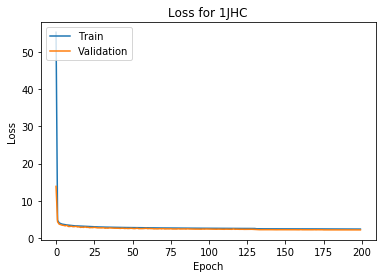

0.5436923 -0.60937184
Training 2JHH out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 359134 samples, validate on 18902 samples
Epoch 1/200
 - 10s - loss: 5.5257 - out_loss: 2.0968 - outM2_loss: 0.2593 - outT6_loss: 2.3560 - outT12_loss: 0.8136 - val_loss: 4.0152 - val_out_loss: 0.8232 - val_outM2_loss: 0.2796 - val_outT6_loss: 2.1085 - val_outT12_loss: 0.8039
Epoch 2/200
 - 8s - loss: 3.5933 - out_loss: 0.4997 - outM2_loss: 0.1832 - outT6_loss: 2.1084 - outT12_loss: 0.8019 - val_loss: 3.2968 - val_out_loss: 0.4235 - val_outM2_loss: 0.1128 - val_outT6_loss: 1.9605 - val_outT12_loss: 0.8000
Epoch 3/200
 - 8s - loss: 3.4323 - out_loss: 0.4446 - outM2_loss: 0.1686 - outT6_loss: 2.0188 - outT12_loss: 0.8004 - val_loss: 3.1855 - val_out_loss: 0.3454 - val_outM2_loss: 0.1452 - val_outT6_loss: 1.8962 - val_outT12_loss: 0.7987
Epoch 4/200
 - 8s - loss: 3.3298 - out_loss: 0.4095 - outM2_loss: 0.1580 - outT6_loss: 1.9632 - outT12_loss: 0.7991 - val_loss: 3.1178 - val_ou

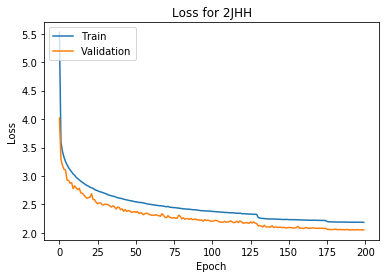

0.13204324 -2.0246258
Training 1JHN out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 41194 samples, validate on 2169 samples
Epoch 1/200
 - 3s - loss: 48.5067 - out_loss: 45.2051 - outM2_loss: 0.5857 - outT6_loss: 1.9322 - outT12_loss: 0.7837 - val_loss: 43.5258 - val_out_loss: 39.8810 - val_outM2_loss: 0.8663 - val_outT6_loss: 2.0653 - val_outT12_loss: 0.7132
Epoch 2/200
 - 1s - loss: 45.0741 - out_loss: 42.4764 - outM2_loss: 0.2982 - outT6_loss: 1.6019 - outT12_loss: 0.6976 - val_loss: 42.1993 - val_out_loss: 39.6037 - val_outM2_loss: 0.3557 - val_outT6_loss: 1.5506 - val_outT12_loss: 0.6892
Epoch 3/200
 - 1s - loss: 42.4556 - out_loss: 40.0354 - outM2_loss: 0.2602 - outT6_loss: 1.4693 - outT12_loss: 0.6907 - val_loss: 39.9875 - val_out_loss: 37.6122 - val_outM2_loss: 0.2314 - val_outT6_loss: 1.4540 - val_outT12_loss: 0.6897
Epoch 4/200
 - 1s - loss: 39.5026 - out_loss: 37.1464 - outM2_loss: 0.2601 - outT6_loss: 1.4082 - outT12_loss: 0.6879 - val_loss: 36.9

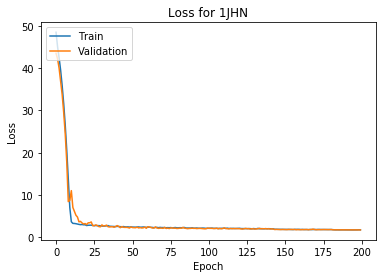

0.2624262 -1.3377854
Training 2JHN out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 113290 samples, validate on 5963 samples
Epoch 1/200
 - 5s - loss: 3.9006 - out_loss: 0.8086 - outM2_loss: 0.3930 - outT6_loss: 1.9394 - outT12_loss: 0.7596 - val_loss: 3.3659 - val_out_loss: 0.5624 - val_outM2_loss: 0.3216 - val_outT6_loss: 1.7571 - val_outT12_loss: 0.7247
Epoch 2/200
 - 2s - loss: 3.0886 - out_loss: 0.4506 - outM2_loss: 0.2324 - outT6_loss: 1.6815 - outT12_loss: 0.7241 - val_loss: 3.0112 - val_out_loss: 0.4608 - val_outM2_loss: 0.2345 - val_outT6_loss: 1.5970 - val_outT12_loss: 0.7188
Epoch 3/200
 - 2s - loss: 2.9292 - out_loss: 0.4158 - outM2_loss: 0.1964 - outT6_loss: 1.5968 - outT12_loss: 0.7202 - val_loss: 2.8394 - val_out_loss: 0.4054 - val_outM2_loss: 0.2044 - val_outT6_loss: 1.5153 - val_outT12_loss: 0.7143
Epoch 4/200
 - 2s - loss: 2.8233 - out_loss: 0.3819 - outM2_loss: 0.1889 - outT6_loss: 1.5346 - outT12_loss: 0.7179 - val_loss: 2.7149 - val_out_l

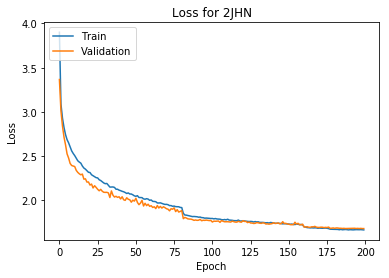

0.13257861 -2.0205796
Training 2JHC out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 1083640 samples, validate on 57034 samples
Epoch 1/200
 - 25s - loss: 3.5923 - out_loss: 0.9066 - outM2_loss: 0.2119 - outT6_loss: 1.7654 - outT12_loss: 0.7084 - val_loss: 3.0666 - val_out_loss: 0.6766 - val_outM2_loss: 0.1166 - val_outT6_loss: 1.5722 - val_outT12_loss: 0.7013
Epoch 2/200
 - 23s - loss: 3.0999 - out_loss: 0.6689 - outM2_loss: 0.1533 - outT6_loss: 1.5792 - outT12_loss: 0.6985 - val_loss: 2.8621 - val_out_loss: 0.5946 - val_outM2_loss: 0.1019 - val_outT6_loss: 1.4676 - val_outT12_loss: 0.6980
Epoch 3/200
 - 23s - loss: 2.9290 - out_loss: 0.5981 - outM2_loss: 0.1374 - outT6_loss: 1.4964 - outT12_loss: 0.6971 - val_loss: 2.7071 - val_out_loss: 0.5232 - val_outM2_loss: 0.0878 - val_outT6_loss: 1.3982 - val_outT12_loss: 0.6980
Epoch 4/200
 - 23s - loss: 2.8210 - out_loss: 0.5553 - outM2_loss: 0.1289 - outT6_loss: 1.4404 - outT12_loss: 0.6964 - val_loss: 2.6184 - va

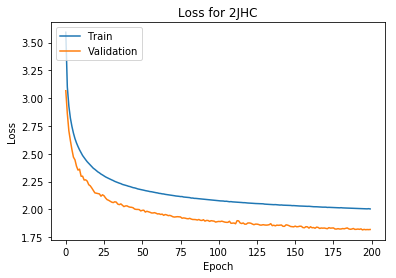

0.23145524 -1.4633688
Training 3JHH out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 561080 samples, validate on 29531 samples
Epoch 1/200
 - 14s - loss: 4.0712 - out_loss: 0.7505 - outM2_loss: 0.2430 - outT6_loss: 2.3098 - outT12_loss: 0.7680 - val_loss: 3.5788 - val_out_loss: 0.5376 - val_outM2_loss: 0.2076 - val_outT6_loss: 2.0786 - val_outT12_loss: 0.7549
Epoch 2/200
 - 12s - loss: 3.4974 - out_loss: 0.5094 - outM2_loss: 0.1664 - outT6_loss: 2.0649 - outT12_loss: 0.7568 - val_loss: 3.1907 - val_out_loss: 0.4032 - val_outM2_loss: 0.0983 - val_outT6_loss: 1.9366 - val_outT12_loss: 0.7526
Epoch 3/200
 - 12s - loss: 3.3348 - out_loss: 0.4620 - outM2_loss: 0.1549 - outT6_loss: 1.9627 - outT12_loss: 0.7552 - val_loss: 3.0968 - val_out_loss: 0.3933 - val_outM2_loss: 0.1023 - val_outT6_loss: 1.8492 - val_outT12_loss: 0.7520
Epoch 4/200
 - 12s - loss: 3.2260 - out_loss: 0.4300 - outM2_loss: 0.1455 - outT6_loss: 1.8968 - outT12_loss: 0.7537 - val_loss: 2.9722 - val

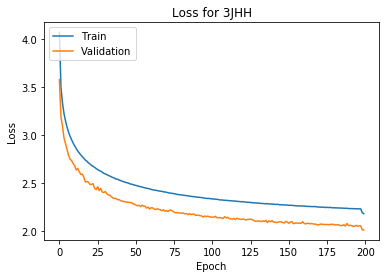

0.15949553 -1.8357394
Training 3JHC out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 1434860 samples, validate on 75519 samples
Epoch 1/200
 - 33s - loss: 3.5566 - out_loss: 0.8944 - outM2_loss: 0.2027 - outT6_loss: 1.7528 - outT12_loss: 0.7067 - val_loss: 2.9887 - val_out_loss: 0.6645 - val_outM2_loss: 0.0855 - val_outT6_loss: 1.5392 - val_outT12_loss: 0.6995
Epoch 2/200
 - 31s - loss: 3.1027 - out_loss: 0.6994 - outM2_loss: 0.1490 - outT6_loss: 1.5549 - outT12_loss: 0.6993 - val_loss: 2.7848 - val_out_loss: 0.5877 - val_outM2_loss: 0.0695 - val_outT6_loss: 1.4315 - val_outT12_loss: 0.6961
Epoch 3/200
 - 31s - loss: 2.9406 - out_loss: 0.6324 - outM2_loss: 0.1365 - outT6_loss: 1.4736 - outT12_loss: 0.6981 - val_loss: 2.6838 - val_out_loss: 0.5402 - val_outM2_loss: 0.0851 - val_outT6_loss: 1.3624 - val_outT12_loss: 0.6960
Epoch 4/200
 - 31s - loss: 2.8363 - out_loss: 0.5901 - outM2_loss: 0.1278 - outT6_loss: 1.4208 - outT12_loss: 0.6976 - val_loss: 2.5822 - va

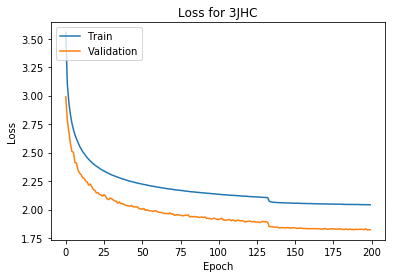

0.23234315 -1.4595399
Training 3JHN out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 158094 samples, validate on 8321 samples
Epoch 1/200
 - 6s - loss: 3.4154 - out_loss: 0.4928 - outM2_loss: 0.3418 - outT6_loss: 1.8396 - outT12_loss: 0.7412 - val_loss: 3.0823 - val_out_loss: 0.3900 - val_outM2_loss: 0.3309 - val_outT6_loss: 1.6445 - val_outT12_loss: 0.7170
Epoch 2/200
 - 3s - loss: 2.8637 - out_loss: 0.3450 - outM2_loss: 0.2136 - outT6_loss: 1.5970 - outT12_loss: 0.7081 - val_loss: 2.7568 - val_out_loss: 0.3191 - val_outM2_loss: 0.2150 - val_outT6_loss: 1.5131 - val_outT12_loss: 0.7097
Epoch 3/200
 - 3s - loss: 2.7106 - out_loss: 0.3126 - outM2_loss: 0.1860 - outT6_loss: 1.5074 - outT12_loss: 0.7046 - val_loss: 2.5528 - val_out_loss: 0.2702 - val_outM2_loss: 0.1629 - val_outT6_loss: 1.4103 - val_outT12_loss: 0.7094
Epoch 4/200
 - 3s - loss: 2.6162 - out_loss: 0.2890 - outM2_loss: 0.1748 - outT6_loss: 1.4501 - outT12_loss: 0.7024 - val_loss: 2.4504 - val_out_

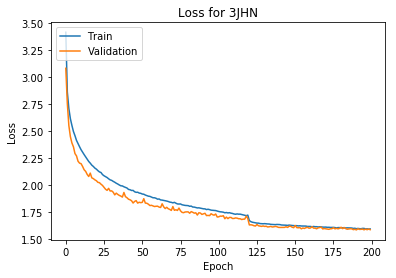

0.10422893 -2.2611656


In [18]:
from datetime import datetime

mol_types=df_train["type"].unique()
cv_score=[]
cv_score_total=0
epoch_n = 200
verbose = 2
batch_size = 1024
    
# Set to True if we want to train from scratch.  False will reuse saved models as a starting point.
retrain = True


# Set up GPU preferences
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} ) 
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = tf.Session(config=config) 
K.set_session(sess)

start_time=datetime.now()

# Loop through each molecule type
for mol_type in mol_types:
    model_name_rd = ('../keras-neural-net-for-champs/molecule_model_%s.hdf5' % mol_type)
    model_name_wrt = ('molecule_model_%s.hdf5' % mol_type)
    print('Training %s' % mol_type, 'out of', mol_types, '\n')
    
    df_train_ = df_train[df_train["type"]==mol_type]
    df_test_  = df_test [ df_test["type"]==mol_type]

    # Here's our best features.  We think.
    input_features=[
        "x_0","y_0","z_0","x_1","y_1","z_1","c_x","c_y","c_z",
                    'x_closest_0','y_closest_0','z_closest_0','x_closest_1','y_closest_1','z_closest_1',
                    "distance","distance_center0","distance_center1", "distance_c0","distance_c1","distance_f0","distance_f1",
                    "cos_c0_c1","cos_f0_f1","cos_center0_center1","cos_c0","cos_c1","cos_f0","cos_f1","cos_center0","cos_center1",
                    "atom_n",
                        'link0', 'dist_xyz', 'inv_dist0',
       'inv_dist1', 'inv_distP', 'inv_dist0R', 'inv_dist1R', 'inv_distPR',
       'inv_dist0E', 'linkM0', 'min_molecule_atom_0_dist_xyz',
       'mean_molecule_atom_0_dist_xyz', 'max_molecule_atom_0_dist_xyz',
       'sd_molecule_atom_0_dist_xyz', 'min_molecule_atom_1_dist_xyz',
       'mean_molecule_atom_1_dist_xyz', 'max_molecule_atom_1_dist_xyz',
       'distN0', 'distN1', 'bond_lengths_mean_y', 'bond_lengths_std_y',
       'yukawa_C.x', 'yukawa_H.x', 'yukawa_N.x', 'yukawa_O.x', 'yukawa_C.y',
       'yukawa_H.y', 'yukawa_N.y', 'yukawa_O.y', 'qm9_1', 'qm9_2', 'adH1',
       'adC1', 'adC2', 'adC3', 'adC4', 'adC5', 'adN1', 'adN2', 'F1dist1',
       'F1dist2', 'F1dist3', 'bond_atom', 'bond_distance', 'tertiary_angle_0',
       'tertiary_angle_1', 'tertiary_angle_2', 'tertiary_angle_3',
       'tertiary_angle_4', 'tertiary_angle_5', 'tertiary_angle_6',
       'tertiary_angle_7', 'tertiary_distance_0', 'tertiary_distance_1',
       'tertiary_distance_2', 'tertiary_distance_3', 'tertiary_distance_4',
       'tertiary_distance_5', 'tertiary_distance_6', 'tertiary_distance_7',
    ]

    # Standard Scaler from sklearn does seem to work better here than other Scalers
    input_data=StandardScaler().fit_transform(pd.concat([df_train_.loc[:,input_features],df_test_.loc[:,input_features]]))
    
    target_data=df_train_.loc[:,"scalar_coupling_constant"].values
    target_data_1=df_train_.loc[:,["charge_0","charge_1"]]
    target_data_2=df_train_.loc[:,["XX_0","YY_0","ZZ_0","XX_1","YY_1","ZZ_1"]]
    target_data_3=df_train_.loc[:,["YX_0","ZX_0","XY_0","ZY_0","XZ_0","YZ_0","YX_1","ZX_1","XY_1","ZY_1","XZ_1","YZ_1"]]
    
    #following parameters should be adjusted to control the loss function
    #if all parameters are zero, attractors do not work. (-> simple neural network)
    m1=2
    m2=4
    m3=1
    target_data_1=m1*(StandardScaler().fit_transform(target_data_1))
    target_data_2=m2*(StandardScaler().fit_transform(target_data_2))
    target_data_3=m3*(StandardScaler().fit_transform(target_data_3))
    
    # Simple split to provide us a validation set to do our CV checks with
    train_index, cv_index = train_test_split(np.arange(len(df_train_)),random_state=111, test_size=0.05)
    
    # Split all our input and targets by train and cv indexes
    train_input=input_data[train_index]
    cv_input=input_data[cv_index]
    train_target=target_data[train_index]
    cv_target=target_data[cv_index]
    train_target_1=target_data_1[train_index]
    cv_target_1=target_data_1[cv_index]
    train_target_2=target_data_2[train_index]
    cv_target_2=target_data_2[cv_index]
    train_target_3=target_data_3[train_index]
    cv_target_3=target_data_3[cv_index]
    test_input=input_data[len(df_train_):,:]

    # Build the Neural Net
    nn_model=create_nn_model(train_input.shape[1])
    
    # If retrain==False, then we load a previous saved model as a starting point.
    if not retrain:
        nn_model = load_model(model_name_rd)
        
    nn_model.compile(loss='mae', optimizer=Adam())#, metrics=[auc])
    #nn_model.compile(loss='mean_squared_error', optimizer=Adam())#, metrics=[auc])
    
    # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
    es = callbacks.EarlyStopping(monitor='val_out_loss', min_delta=0.0005, patience=30,verbose=1, mode='auto', restore_best_weights=True)
    # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
    rlr = callbacks.ReduceLROnPlateau(monitor='val_out_loss', factor=0.3333,patience=15, min_lr=1e-6, mode='auto', verbose=1)
    # Save the best value of the model for future use
    sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_out_loss', save_best_only=True, period=1)

    history = nn_model.fit(train_input,[train_target,train_target_1,train_target_2,train_target_3], 
                           validation_data=(cv_input,[cv_target,cv_target_1,cv_target_2,cv_target_3]), 
                           callbacks=[es, rlr, sv_mod],
                           epochs=epoch_n,
                           batch_size=batch_size,
                           verbose=verbose)
    
    cv_predict=nn_model.predict(cv_input)
    plot_history(history, mol_type)
    
    accuracy=np.mean(np.abs(cv_target-cv_predict[0][:,0]))
    print( accuracy,np.log(accuracy) )
    
    cv_score.append(np.log(accuracy))
    cv_score_total+=np.log(accuracy)
    
    # Predict on the test data set using our trained model
    test_predict=nn_model.predict(test_input)
    
    # for each molecule type we'll grab the predicted values
    test_prediction[df_test["type"]==mol_type]=test_predict[0][:,0]
    K.clear_session()

cv_score_total/=len(mol_types)

In [19]:
print ('Total training time: ', datetime.now() - start_time)

i=0
for mol_type in mol_types: 
    print(mol_type,": cv score is ",cv_score[i])
    i+=1
print("total cv score is",cv_score_total)

Total training time:  5:22:32.975131
1JHC : cv score is  -0.60937184
2JHH : cv score is  -2.0246258
1JHN : cv score is  -1.3377854
2JHN : cv score is  -2.0205796
2JHC : cv score is  -1.4633688
3JHH : cv score is  -1.8357394
3JHC : cv score is  -1.4595399
3JHN : cv score is  -2.2611656
total cv score is -1.6265220269560814


## Prepare results for Submission

The total CV score matches Kaggle's score pretty closely.

In [21]:
def submit(predictions):
    submit = pd.read_csv('../input/sample_submission.csv')
    print(len(submit), len(predictions))   
    submit["scalar_coupling_constant"] = predictions
    submit.to_csv("../submissions/keras-neural-net-1.csv", index=False)
submit(test_prediction)

print ('Total training time: ', datetime.now() - start_time)

i=0
for mol_type in mol_types: 
    print(mol_type,": cv score is ",cv_score[i])
    i+=1
print("total cv score is",cv_score_total)

2505542 2505542
Total training time:  5:23:31.742009
1JHC : cv score is  -0.60937184
2JHH : cv score is  -2.0246258
1JHN : cv score is  -1.3377854
2JHN : cv score is  -2.0205796
2JHC : cv score is  -1.4633688
3JHH : cv score is  -1.8357394
3JHC : cv score is  -1.4595399
3JHN : cv score is  -2.2611656
total cv score is -1.6265220269560814


Training 1JHC out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 673945 samples, validate on 35471 samples
Epoch 1/50
 - 25s - loss: 2.4346 - out_loss: 0.6466 - outM2_loss: 0.0917 - outT6_loss: 0.9946 - outT12_loss: 0.7017 - val_loss: 2.1771 - val_out_loss: 0.5410 - val_outM2_loss: 0.0389 - val_outT6_loss: 0.8930 - val_outT12_loss: 0.7041
Epoch 2/50
 - 22s - loss: 2.4304 - out_loss: 0.6442 - outM2_loss: 0.0911 - outT6_loss: 0.9933 - outT12_loss: 0.7018 - val_loss: 2.1759 - val_out_loss: 0.5404 - val_outM2_loss: 0.0389 - val_outT6_loss: 0.8926 - val_outT12_loss: 0.7041
Epoch 3/50
 - 22s - loss: 2.4315 - out_loss: 0.6447 - outM2_loss: 0.0910 - outT6_loss: 0.9941 - outT12_loss: 0.7017 - val_loss: 2.1784 - val_out_loss: 0.5428 - val_outM2_loss: 0.0388 - val_outT6_loss: 0.8928 - val_outT12_loss: 0.7041
Epoch 4/50
 - 22s - loss: 2.4302 - out_loss: 0.6436 - outM2_loss: 0.0909 - outT6_loss: 0.9941 - outT12_loss: 0.7016 - val_loss: 2.1752 - val_out_loss: 0.5401 - val_ou

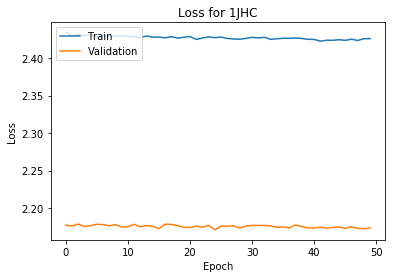

0.539279 -0.61752224
Training 2JHH out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 359134 samples, validate on 18902 samples
Epoch 1/50
 - 14s - loss: 2.2157 - out_loss: 0.1702 - outM2_loss: 0.0991 - outT6_loss: 1.2365 - outT12_loss: 0.7099 - val_loss: 2.0527 - val_out_loss: 0.1291 - val_outM2_loss: 0.0387 - val_outT6_loss: 1.1774 - val_outT12_loss: 0.7075
Epoch 2/50
 - 12s - loss: 2.2120 - out_loss: 0.1708 - outM2_loss: 0.0982 - outT6_loss: 1.2335 - outT12_loss: 0.7095 - val_loss: 2.0514 - val_out_loss: 0.1289 - val_outM2_loss: 0.0381 - val_outT6_loss: 1.1770 - val_outT12_loss: 0.7074
Epoch 3/50
 - 12s - loss: 2.2089 - out_loss: 0.1697 - outM2_loss: 0.0974 - outT6_loss: 1.2325 - outT12_loss: 0.7093 - val_loss: 2.0527 - val_out_loss: 0.1301 - val_outM2_loss: 0.0379 - val_outT6_loss: 1.1773 - val_outT12_loss: 0.7074
Epoch 4/50
 - 12s - loss: 2.2099 - out_loss: 0.1693 - outM2_loss: 0.0979 - outT6_loss: 1.2337 - outT12_loss: 0.7090 - val_loss: 2.0512 - val_out_

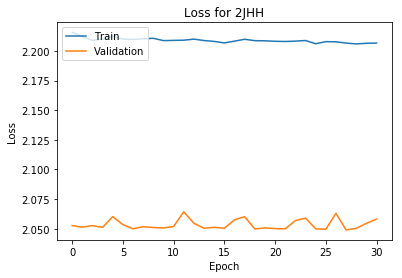

0.1291339 -2.0469055
Training 1JHN out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 41194 samples, validate on 2169 samples
Epoch 1/50
 - 4s - loss: 1.8263 - out_loss: 0.3754 - outM2_loss: 0.1066 - outT6_loss: 0.7232 - outT12_loss: 0.6212 - val_loss: 1.7499 - val_out_loss: 0.2629 - val_outM2_loss: 0.0436 - val_outT6_loss: 0.7970 - val_outT12_loss: 0.6464
Epoch 2/50
 - 1s - loss: 1.8215 - out_loss: 0.3755 - outM2_loss: 0.1044 - outT6_loss: 0.7203 - outT12_loss: 0.6213 - val_loss: 1.7483 - val_out_loss: 0.2625 - val_outM2_loss: 0.0436 - val_outT6_loss: 0.7958 - val_outT12_loss: 0.6464
Epoch 3/50
 - 1s - loss: 1.8245 - out_loss: 0.3757 - outM2_loss: 0.1053 - outT6_loss: 0.7217 - outT12_loss: 0.6218 - val_loss: 1.7499 - val_out_loss: 0.2640 - val_outM2_loss: 0.0436 - val_outT6_loss: 0.7959 - val_outT12_loss: 0.6463
Epoch 4/50
 - 1s - loss: 1.8080 - out_loss: 0.3648 - outM2_loss: 0.1040 - outT6_loss: 0.7179 - outT12_loss: 0.6213 - val_loss: 1.7516 - val_out_loss: 

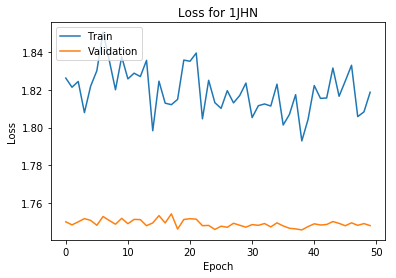

0.2639349 -1.3320527
Training 2JHN out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 113290 samples, validate on 5963 samples
Epoch 1/50
 - 6s - loss: 1.6983 - out_loss: 0.1462 - outM2_loss: 0.1037 - outT6_loss: 0.8006 - outT12_loss: 0.6478 - val_loss: 1.6805 - val_out_loss: 0.1327 - val_outM2_loss: 0.0429 - val_outT6_loss: 0.8399 - val_outT12_loss: 0.6650
Epoch 2/50
 - 4s - loss: 1.7035 - out_loss: 0.1500 - outM2_loss: 0.1045 - outT6_loss: 0.8013 - outT12_loss: 0.6477 - val_loss: 1.6807 - val_out_loss: 0.1331 - val_outM2_loss: 0.0434 - val_outT6_loss: 0.8392 - val_outT12_loss: 0.6650
Epoch 3/50
 - 4s - loss: 1.6970 - out_loss: 0.1450 - outM2_loss: 0.1056 - outT6_loss: 0.7986 - outT12_loss: 0.6478 - val_loss: 1.6805 - val_out_loss: 0.1331 - val_outM2_loss: 0.0430 - val_outT6_loss: 0.8394 - val_outT12_loss: 0.6649
Epoch 4/50
 - 4s - loss: 1.6988 - out_loss: 0.1475 - outM2_loss: 0.1041 - outT6_loss: 0.7995 - outT12_loss: 0.6477 - val_loss: 1.6816 - val_out_loss:

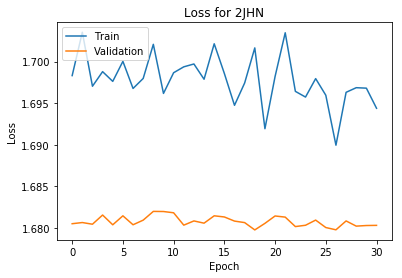

0.13267076 -2.0198848
Training 2JHC out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 1083640 samples, validate on 57034 samples
Epoch 1/50
 - 38s - loss: 2.0026 - out_loss: 0.2706 - outM2_loss: 0.0677 - outT6_loss: 0.9865 - outT12_loss: 0.6778 - val_loss: 1.7894 - val_out_loss: 0.2202 - val_outM2_loss: 0.0325 - val_outT6_loss: 0.8622 - val_outT12_loss: 0.6745
Epoch 2/50
 - 36s - loss: 1.9949 - out_loss: 0.2678 - outM2_loss: 0.0673 - outT6_loss: 0.9824 - outT12_loss: 0.6774 - val_loss: 1.7854 - val_out_loss: 0.2190 - val_outM2_loss: 0.0317 - val_outT6_loss: 0.8604 - val_outT12_loss: 0.6743
Epoch 3/50
 - 36s - loss: 1.9927 - out_loss: 0.2669 - outM2_loss: 0.0671 - outT6_loss: 0.9814 - outT12_loss: 0.6772 - val_loss: 1.7833 - val_out_loss: 0.2183 - val_outM2_loss: 0.0316 - val_outT6_loss: 0.8592 - val_outT12_loss: 0.6742
Epoch 4/50
 - 36s - loss: 1.9898 - out_loss: 0.2662 - outM2_loss: 0.0669 - outT6_loss: 0.9797 - outT12_loss: 0.6771 - val_loss: 1.7815 - val_ou

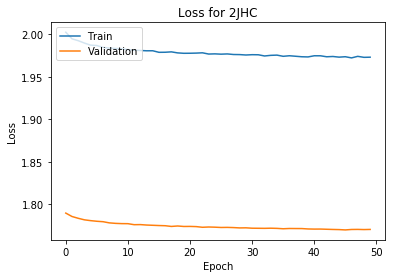

0.21413848 -1.5411323
Training 3JHH out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 561080 samples, validate on 29531 samples
Epoch 1/50
 - 21s - loss: 2.2031 - out_loss: 0.2002 - outM2_loss: 0.0794 - outT6_loss: 1.2224 - outT12_loss: 0.7011 - val_loss: 2.0052 - val_out_loss: 0.1563 - val_outM2_loss: 0.0347 - val_outT6_loss: 1.1202 - val_outT12_loss: 0.6940
Epoch 2/50
 - 19s - loss: 2.1993 - out_loss: 0.1989 - outM2_loss: 0.0794 - outT6_loss: 1.2201 - outT12_loss: 0.7009 - val_loss: 2.0029 - val_out_loss: 0.1559 - val_outM2_loss: 0.0345 - val_outT6_loss: 1.1186 - val_outT12_loss: 0.6939
Epoch 3/50
 - 19s - loss: 2.1958 - out_loss: 0.1985 - outM2_loss: 0.0787 - outT6_loss: 1.2179 - outT12_loss: 0.7007 - val_loss: 2.0028 - val_out_loss: 0.1557 - val_outM2_loss: 0.0350 - val_outT6_loss: 1.1182 - val_outT12_loss: 0.6939
Epoch 4/50
 - 19s - loss: 2.1965 - out_loss: 0.1983 - outM2_loss: 0.0792 - outT6_loss: 1.2183 - outT12_loss: 0.7008 - val_loss: 2.0013 - val_out

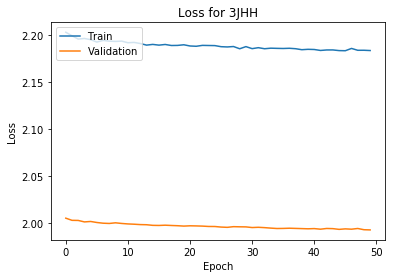

0.15423185 -1.8692983
Training 3JHC out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 1434860 samples, validate on 75519 samples
Epoch 1/50
 - 50s - loss: 2.0557 - out_loss: 0.2981 - outM2_loss: 0.0681 - outT6_loss: 1.0064 - outT12_loss: 0.6831 - val_loss: 1.8125 - val_out_loss: 0.2300 - val_outM2_loss: 0.0316 - val_outT6_loss: 0.8724 - val_outT12_loss: 0.6786
Epoch 2/50
 - 47s - loss: 2.0532 - out_loss: 0.2970 - outM2_loss: 0.0678 - outT6_loss: 1.0054 - outT12_loss: 0.6830 - val_loss: 1.8123 - val_out_loss: 0.2293 - val_outM2_loss: 0.0321 - val_outT6_loss: 0.8722 - val_outT12_loss: 0.6786
Epoch 3/50
 - 48s - loss: 2.0514 - out_loss: 0.2963 - outM2_loss: 0.0676 - outT6_loss: 1.0044 - outT12_loss: 0.6830 - val_loss: 1.8103 - val_out_loss: 0.2293 - val_outM2_loss: 0.0311 - val_outT6_loss: 0.8714 - val_outT12_loss: 0.6785
Epoch 4/50
 - 48s - loss: 2.0510 - out_loss: 0.2961 - outM2_loss: 0.0676 - outT6_loss: 1.0042 - outT12_loss: 0.6830 - val_loss: 1.8107 - val_ou

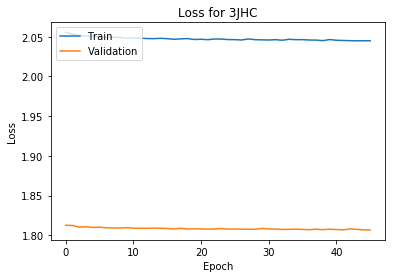

0.22811124 -1.4779218
Training 3JHN out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 158094 samples, validate on 8321 samples
Epoch 1/50
 - 7s - loss: 1.6107 - out_loss: 0.1098 - outM2_loss: 0.0928 - outT6_loss: 0.7744 - outT12_loss: 0.6337 - val_loss: 1.5761 - val_out_loss: 0.0996 - val_outM2_loss: 0.0407 - val_outT6_loss: 0.7742 - val_outT12_loss: 0.6617
Epoch 2/50
 - 5s - loss: 1.6064 - out_loss: 0.1094 - outM2_loss: 0.0923 - outT6_loss: 0.7716 - outT12_loss: 0.6332 - val_loss: 1.5743 - val_out_loss: 0.0994 - val_outM2_loss: 0.0403 - val_outT6_loss: 0.7732 - val_outT12_loss: 0.6614
Epoch 3/50
 - 5s - loss: 1.6028 - out_loss: 0.1093 - outM2_loss: 0.0913 - outT6_loss: 0.7695 - outT12_loss: 0.6328 - val_loss: 1.5734 - val_out_loss: 0.0993 - val_outM2_loss: 0.0401 - val_outT6_loss: 0.7728 - val_outT12_loss: 0.6613
Epoch 4/50
 - 5s - loss: 1.6029 - out_loss: 0.1089 - outM2_loss: 0.0929 - outT6_loss: 0.7686 - outT12_loss: 0.6325 - val_loss: 1.5729 - val_out_loss

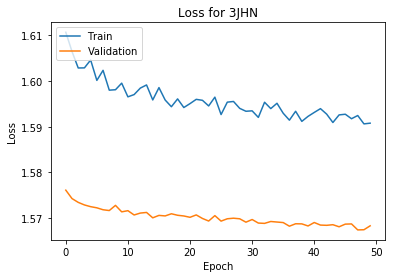

0.099012546 -2.3125088


In [23]:
mol_types=df_train["type"].unique()
cv_score=[]
cv_score_total=0
epoch_n = 50
verbose = 2
batch_size = 512
    
# Set to True if we want to train from scratch.  False will reuse saved models as a starting point.
retrain = True


# Set up GPU preferences
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} ) 
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = tf.Session(config=config) 
K.set_session(sess)

start_time=datetime.now()

# Loop through each molecule type
for mol_type in mol_types:
    model_name_rd = ('../keras-neural-net-for-champs/molecule_model_%s.hdf5' % mol_type)
    model_name_wrt = ('working/molecule_model_%s.hdf5' % mol_type)
    print('Training %s' % mol_type, 'out of', mol_types, '\n')
    
    df_train_ = df_train[df_train["type"]==mol_type]
    df_test_  = df_test [ df_test["type"]==mol_type]

    # Here's our best features.  We think.
    input_features=[
        "x_0","y_0","z_0","x_1","y_1","z_1","c_x","c_y","c_z",
                    'x_closest_0','y_closest_0','z_closest_0','x_closest_1','y_closest_1','z_closest_1',
                    "distance","distance_center0","distance_center1", "distance_c0","distance_c1","distance_f0","distance_f1",
                    "cos_c0_c1","cos_f0_f1","cos_center0_center1","cos_c0","cos_c1","cos_f0","cos_f1","cos_center0","cos_center1",
                    "atom_n",
                        'link0', 'dist_xyz', 'inv_dist0',
       'inv_dist1', 'inv_distP', 'inv_dist0R', 'inv_dist1R', 'inv_distPR',
       'inv_dist0E', 'linkM0', 'min_molecule_atom_0_dist_xyz',
       'mean_molecule_atom_0_dist_xyz', 'max_molecule_atom_0_dist_xyz',
       'sd_molecule_atom_0_dist_xyz', 'min_molecule_atom_1_dist_xyz',
       'mean_molecule_atom_1_dist_xyz', 'max_molecule_atom_1_dist_xyz',
       'distN0', 'distN1', 'bond_lengths_mean_y', 'bond_lengths_std_y',
       'yukawa_C.x', 'yukawa_H.x', 'yukawa_N.x', 'yukawa_O.x', 'yukawa_C.y',
       'yukawa_H.y', 'yukawa_N.y', 'yukawa_O.y', 'qm9_1', 'qm9_2', 'adH1',
       'adC1', 'adC2', 'adC3', 'adC4', 'adC5', 'adN1', 'adN2', 'F1dist1',
       'F1dist2', 'F1dist3', 'bond_atom', 'bond_distance', 'tertiary_angle_0',
       'tertiary_angle_1', 'tertiary_angle_2', 'tertiary_angle_3',
       'tertiary_angle_4', 'tertiary_angle_5', 'tertiary_angle_6',
       'tertiary_angle_7', 'tertiary_distance_0', 'tertiary_distance_1',
       'tertiary_distance_2', 'tertiary_distance_3', 'tertiary_distance_4',
       'tertiary_distance_5', 'tertiary_distance_6', 'tertiary_distance_7',
    ]

    # Standard Scaler from sklearn does seem to work better here than other Scalers
    input_data=StandardScaler().fit_transform(pd.concat([df_train_.loc[:,input_features],df_test_.loc[:,input_features]]))
    
    target_data=df_train_.loc[:,"scalar_coupling_constant"].values
    target_data_1=df_train_.loc[:,["charge_0","charge_1"]]
    target_data_2=df_train_.loc[:,["XX_0","YY_0","ZZ_0","XX_1","YY_1","ZZ_1"]]
    target_data_3=df_train_.loc[:,["YX_0","ZX_0","XY_0","ZY_0","XZ_0","YZ_0","YX_1","ZX_1","XY_1","ZY_1","XZ_1","YZ_1"]]
    
    #following parameters should be adjusted to control the loss function
    #if all parameters are zero, attractors do not work. (-> simple neural network)
    m1=2
    m2=4
    m3=1
    target_data_1=m1*(StandardScaler().fit_transform(target_data_1))
    target_data_2=m2*(StandardScaler().fit_transform(target_data_2))
    target_data_3=m3*(StandardScaler().fit_transform(target_data_3))
    
    # Simple split to provide us a validation set to do our CV checks with
    train_index, cv_index = train_test_split(np.arange(len(df_train_)),random_state=111, test_size=0.05)
    
    # Split all our input and targets by train and cv indexes
    train_input=input_data[train_index]
    cv_input=input_data[cv_index]
    train_target=target_data[train_index]
    cv_target=target_data[cv_index]
    train_target_1=target_data_1[train_index]
    cv_target_1=target_data_1[cv_index]
    train_target_2=target_data_2[train_index]
    cv_target_2=target_data_2[cv_index]
    train_target_3=target_data_3[train_index]
    cv_target_3=target_data_3[cv_index]
    test_input=input_data[len(df_train_):,:]

    # Build the Neural Net
    nn_model=create_nn_model(train_input.shape[1])
    
    # If retrain==False, then we load a previous saved model as a starting point.
    #if not retrain:
    nn_model = load_model(model_name_rd)
        
    nn_model.compile(loss='mae', optimizer=Adam(lr=0.00001))#, metrics=[auc])
    #nn_model.compile(loss='mean_squared_error', optimizer=Adam())#, metrics=[auc])
    
    # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
    es = callbacks.EarlyStopping(monitor='val_out_loss', min_delta=0.0005, patience=30,verbose=1, mode='auto', restore_best_weights=True)
    # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
    rlr = callbacks.ReduceLROnPlateau(monitor='val_out_loss', factor=0.3333,patience=15, min_lr=1e-6, mode='auto', verbose=1)
    # Save the best value of the model for future use
    sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_out_loss', save_best_only=True, period=1)

    history = nn_model.fit(train_input,[train_target,train_target_1,train_target_2,train_target_3], 
                           validation_data=(cv_input,[cv_target,cv_target_1,cv_target_2,cv_target_3]), 
                           callbacks=[es, rlr, sv_mod],
                           epochs=epoch_n,
                           batch_size=batch_size,
                           verbose=verbose)
    
    cv_predict=nn_model.predict(cv_input)
    plot_history(history, mol_type)
    
    accuracy=np.mean(np.abs(cv_target-cv_predict[0][:,0]))
    print( accuracy,np.log(accuracy) )
    
    cv_score.append(np.log(accuracy))
    cv_score_total+=np.log(accuracy)
    
    # Predict on the test data set using our trained model
    test_predict=nn_model.predict(test_input)
    
    # for each molecule type we'll grab the predicted values
    test_prediction[df_test["type"]==mol_type]=test_predict[0][:,0]
    K.clear_session()

cv_score_total/=len(mol_types)



In [ ]:
# 1JHC : cv score is  -0.60937184
# 2JHH : cv score is  -2.0246258
# 1JHN : cv score is  -1.3377854
# 2JHN : cv score is  -2.0205796
# 2JHC : cv score is  -1.4633688
# 3JHH : cv score is  -1.8357394
# 3JHC : cv score is  -1.4595399
# 3JHN : cv score is  -2.2611656
# total cv score is -1.6265220269560814

In [24]:
def submit(predictions):
    submit = pd.read_csv('../input/sample_submission.csv')
    print(len(submit), len(predictions))   
    submit["scalar_coupling_constant"] = predictions
    submit.to_csv("../submissions/keras-neural-net-1-ft.csv", index=False)
submit(test_prediction)

print ('Total training time: ', datetime.now() - start_time)

i=0
for mol_type in mol_types: 
    print(mol_type,": cv score is ",cv_score[i])
    i+=1
print("total cv score is",cv_score_total)

2505542 2505542
Total training time:  1:58:36.433869
1JHC : cv score is  -0.61752224
2JHH : cv score is  -2.0469055
1JHN : cv score is  -1.3320527
2JHN : cv score is  -2.0198848
2JHC : cv score is  -1.5411323
3JHH : cv score is  -1.8692983
3JHC : cv score is  -1.4779218
3JHN : cv score is  -2.3125088
total cv score is -1.6521533280611038
